#Scraping Top 50 Comments from the Top 100 Posts

##(Subreddits: MadeMeSmile, MildlyInfuriating, AskReddit, NoStupidQuestions)


In [ ]:
import praw
import pandas as pd
from datetime import datetime

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id='snGj3Vt2c6CvjjqoSQtRFw',
    client_secret='iIw3K7XiGVv7GARjTitZ2bTgICPq5w',
    user_agent="CommentScraper by u/Scared_Confusion_101"
)

# Subreddit to scrape
subreddits = ['AskReddit', 'MadeMeSmile', 'MildlyInfuriating', 'NoStupidQuestions'] # Run each one seperately to avoid maxing out API calls
NUM_POSTS = 100
TOP_COMMENTS = 50

for sub in subreddits:
    print(f"Scraping subreddit: r/{sub}")
    subreddit = reddit.subreddit(sub)
    sub_data = []

    for submission in subreddit.top(limit=NUM_POSTS):
        submission.comment_sort = 'top'
        submission.comments.replace_more(limit=0)
        comments = submission.comments[:TOP_COMMENTS]

        for comment in comments:
            sub_data.append({
                'subreddit': sub,
                'post_title': submission.title,
                'post_id': submission.id,
                'comment_id': comment.id,
                'comment_body': comment.body,
                'comment_author': str(comment.author),
                'comment_score': comment.score,
                'created_utc': datetime.utcfromtimestamp(comment.created_utc)
            })

    # Save this subreddit's comments to a CSV
    df = pd.DataFrame(sub_data)
    filename = f'{sub}_top50comments_from_top100posts.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} comments to {filename}")


#Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# load files
files = {
    'AskReddit': '/content/drive/MyDrive/Reddit/Final Data/AskReddit_top50comments_from_top100posts.csv',
    'MadeMeSmile': '/content/drive/MyDrive/Reddit/Final Data/MadeMeSmile_top50comments_from_top100posts.csv',
    'NoStupidQuestions': '/content/drive/MyDrive/Reddit/Final Data/NoStupidQuestions_top50comments_from_top100posts.csv',
    'MildlyInfuriating': '/content/drive/MyDrive/Reddit/Final Data/MildlyInfuriating_top50comments_from_top100posts.csv'
}

# combine files
combined_df = pd.concat(
    [pd.read_csv(file).assign(subreddit=sub) for sub, file in files.items()],
    ignore_index=True
)

# print head
combined_df.head()

,subreddit,post_title,post_id,comment_id,comment_body,comment_author,comment_score,created_utc
0,AskReddit,"People who haven't pooped in 2019 yet, why are...",ablzuq,ed1ap8n,It's all I have,NaziGazpacho,46490,2019-01-01 21:07:31
1,AskReddit,"People who haven't pooped in 2019 yet, why are...",ablzuq,ed1dqvy,[deleted],NaN,11066,2019-01-01 21:45:09
2,AskReddit,"People who haven't pooped in 2019 yet, why are...",ablzuq,ed1emmi,Bold of you to assume I'm going to take a shit...,abksploder,34856,2019-01-01 21:56:33
3,AskReddit,"People who haven't pooped in 2019 yet, why are...",ablzuq,ed1e8bh,"""Fuck you, I won't poo when you tell me""",ThreeSheetzToTheWind,28362,2019-01-01 21:51:31
4,AskReddit,"People who haven't pooped in 2019 yet, why are...",ablzuq,ed1c2wr,Everyone now thinking about the last time they...,Lady_Minuit,26828,2019-01-01 21:24:24


In [ ]:
combined_df.isnull().sum()

,0
subreddit,0
post_title,0
post_id,0
comment_id,0
comment_body,0
comment_author,3463
comment_score,0
created_utc,0


In [51]:
print(combined_df.columns)

user_subs = combined_df.groupby('comment_author')['subreddit'].nunique()

multi_sub_users = user_subs[user_subs > 1]

print(f"Number of users in multiple subreddits: {len(multi_sub_users)}")
print(multi_sub_users.sort_values(ascending=False))

multi_user_details = combined_df[combined_df['comment_author'].isin(multi_sub_users.index)]
user_to_subs = multi_user_details.groupby('comment_author')['subreddit'].unique().reset_index()

user_to_subs.head()


Index(['subreddit', 'post_title', 'post_id', 'comment_id', 'comment_body',
       'comment_author', 'comment_score', 'created_utc', 'words'],
      dtype='object')
Number of users in multiple subreddits: 115
comment_author
Hrmpfreally             3
ronchee1                3
8andimpala              2
dick-nipples            2
lennsden                2
                       ..
KingBooRadley           2
JustMeLurkingAround-    2
JustAnotherAviatrix     2
JaggedMetalOs           2
zemorah                 2
Name: subreddit, Length: 115, dtype: int64


,comment_author,subreddit
0,8andimpala,"[MadeMeSmile, MildlyInfuriating]"
1,AdditionalTheory,"[AskReddit, MadeMeSmile]"
2,Aggravating-Hair7931,"[NoStupidQuestions, MildlyInfuriating]"
3,Angie_MJ,"[AskReddit, MadeMeSmile]"
4,AutoModerator,"[AskReddit, MadeMeSmile]"


# Top 10 words in each subreddit

In [ ]:
import spacy
from collections import Counter

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

# Lemmatization and filtering function
def extract_lemmas(text):
    doc = nlp(str(text).lower())
    return [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]

# Apply the function to each comment
combined_df['words'] = combined_df['comment_body'].apply(extract_lemmas)

# Top 10 lemmatized words for each subreddit
for sub in combined_df['subreddit'].unique():
    all_lemmas = [lemma for lemmas in combined_df[combined_df['subreddit'] == sub]['words'] for lemma in lemmas]
    top_lemmas = Counter(all_lemmas).most_common(10)

    print(f"\nTop 10 words in r/{sub}:")
    for word, count in top_lemmas:
        print(f"{word}: {count}")


Top 10 words in r/AskReddit:
like: 989
people: 960
time: 818
know: 681
think: 628
work: 628
get: 623
go: 613
year: 613
day: 601

Top 10 words in r/MadeMeSmile:
like: 617
love: 404
people: 398
good: 379
get: 337
kid: 303
look: 297
time: 297
go: 288
man: 279

Top 10 words in r/NoStupidQuestions:
people: 1170
like: 1030
time: 892
think: 702
know: 605
work: 604
thing: 578
want: 541
go: 541
good: 509

Top 10 words in r/MildlyInfuriating:
like: 666
people: 422
get: 373
time: 358
go: 318
know: 311
look: 288
think: 279
want: 268
work: 255


In [30]:
import spacy
from collections import Counter

# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

# Lemmatization and filtering function
def extract_lemmas(text):
    doc = nlp(str(text).lower())
    return [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]

# Apply the function to each comment
combined_df['words'] = combined_df['comment_body'].apply(extract_lemmas)

# Step 1: Create lemma counters per subreddit
subreddit_lemmas = {}
for sub in combined_df['subreddit'].unique():
    all_lemmas = [
        lemma for lemmas in combined_df[combined_df['subreddit'] == sub]['words']
        for lemma in lemmas
    ]
    subreddit_lemmas[sub] = Counter(all_lemmas)

# Step 2: Find common lemmas across all subreddits
all_common = Counter()
for counter in subreddit_lemmas.values():
    all_common.update(counter)

# Lemmas that appear in 3 or more subreddits (shared/common)
common_lemmas = set()
for lemma in all_common:
    count = sum(lemma in counter for counter in subreddit_lemmas.values())
    if count >= 3:
        common_lemmas.add(lemma)

# Step 3: Print filtered top 20 lemmas per subreddit
for sub, counter in subreddit_lemmas.items():
    filtered = {k: v for k, v in counter.items() if k not in common_lemmas}
    top_unique = Counter(filtered).most_common(20)

    print(f"\nTop 20 **distinctive** words in r/{sub}:")
    for word, count in top_unique:
        print(f"{word}: {count}")



Top 20 **distinctive** words in r/AskReddit:
askreddit: 65
stan: 48
pew: 41
donor: 33
floyd: 33
nsfw: 32
whore: 28
gore: 27
hawk: 24
emu: 23
lee: 21
earther: 20
stephen: 18
reservation: 18
constantinople: 18
nsfl: 17
spock: 16
orlando: 16
shutdown: 15
marvel: 14

Top 20 **distinctive** words in r/MadeMeSmile:
vlc: 52
hawk: 23
mademesmile: 22
gordon: 22
insulin: 18
moo: 17
dee: 16
aww: 14
baseball: 14
di: 14
inflatable: 13
smurf: 13
ronaldo: 13
zelensky: 12
tamale: 12
flail: 12
deng: 12
fuji: 12
mademecry: 11
jean: 11

Top 20 **distinctive** words in r/NoStupidQuestions:
jedi: 65
selfie: 49
propaganda: 41
productive: 34
euthanasia: 29
wiper: 27
buggy: 27
jean: 25
tobacco: 23
smith: 21
scientology: 21
recite: 20
culty: 20
cunty: 20
empire: 19
galaxy: 19
gouging: 18
doesanybodyelse: 18
algorithm: 18
seo: 18

Top 20 **distinctive** words in r/MildlyInfuriating:
airbnb: 35
airpod: 28
hoa: 24
blueberry: 20
amber: 20
receipt: 17
humidity: 17
crab: 17
rug: 17
dean: 15
pepperoni: 15
moldy: 15


In [ ]:
combined_df.to_csv('/content/drive/MyDrive/Reddit/Final Data/combined.csv', index=False)

<ipython-input-13-32ce2efd06df>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


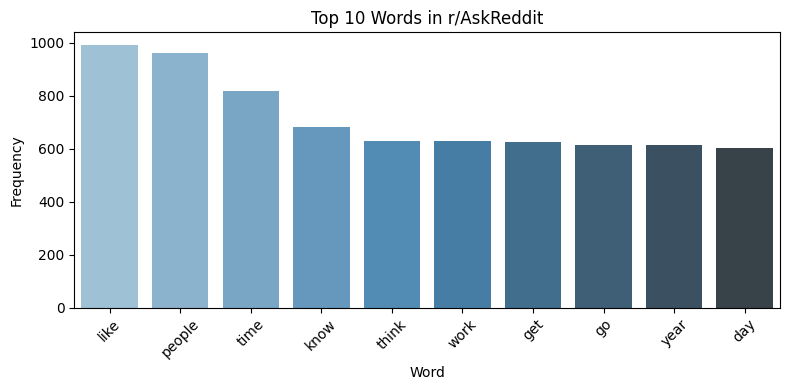

<ipython-input-13-32ce2efd06df>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


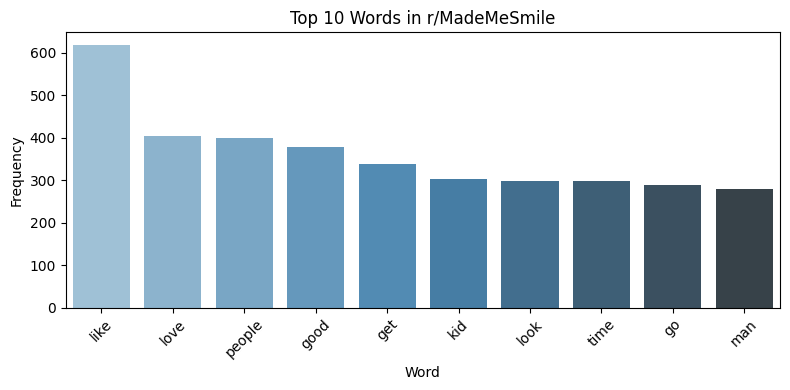

<ipython-input-13-32ce2efd06df>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


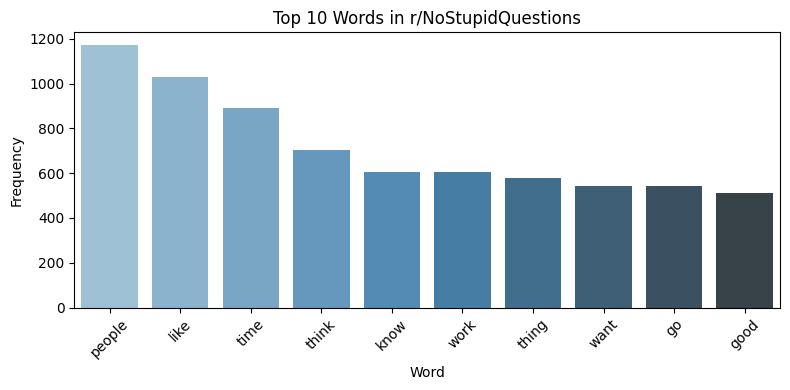

<ipython-input-13-32ce2efd06df>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='Blues_d')


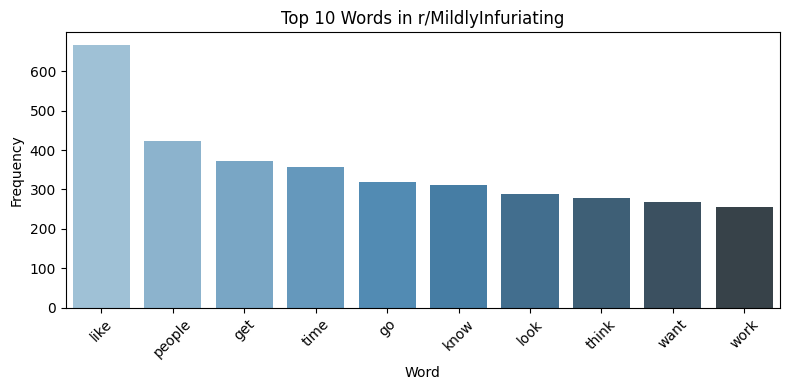

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Already applied: combined_df["lemmas"] = ...

# Plot top 10 lemmas for each subreddit
for sub in combined_df['subreddit'].unique():
    all_lemmas = [lemma for lemmas in combined_df[combined_df['subreddit'] == sub]['words'] for lemma in lemmas]
    top_lemmas = Counter(all_lemmas).most_common(10)

    # Unpack
    words, counts = zip(*top_lemmas)

    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(words), y=list(counts), palette='Blues_d')
    plt.title(f"Top 10 Words in r/{sub}")
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#Sentiment Analysis Using Vader

In [ ]:
!pip install -q vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


Average VADER Sentiment Scores by Subreddit:
                   Negative  Neutral  Positive  Compound
subreddit                                               
AskReddit             0.083    0.813     0.104     0.078
MadeMeSmile           0.063    0.732     0.205     0.277
MildlyInfuriating     0.105    0.793     0.102    -0.002
NoStupidQuestions     0.078    0.814     0.108     0.095

Number of comments per subreddit:
subreddit
MildlyInfuriating    4970
MadeMeSmile          4961
NoStupidQuestions    4941
AskReddit            4911
Name: count, dtype: int64


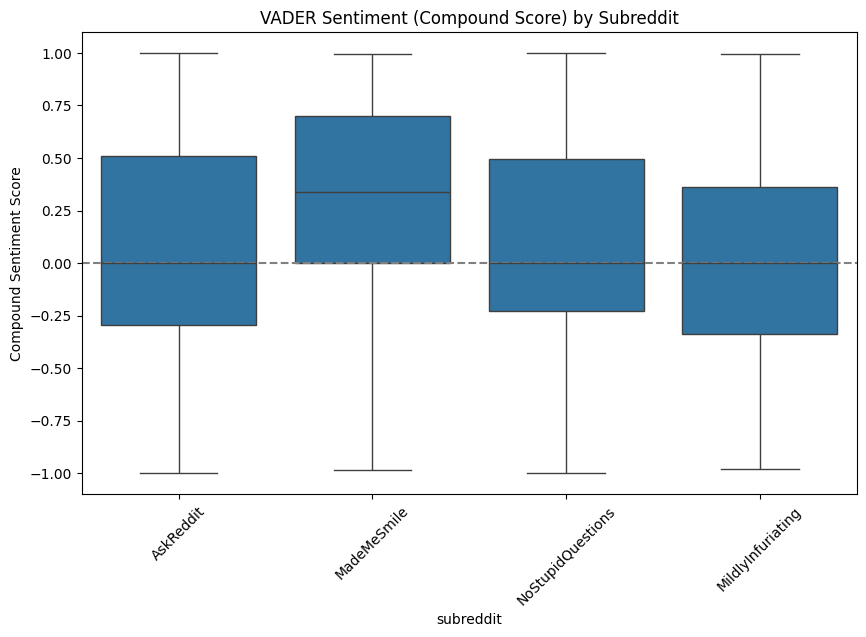

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

# Apply to dataframe
combined_df[['Negative', 'Neutral', 'Positive', 'Compound']] = combined_df['comment_body'].apply(get_vader_sentiment)

# Summary
summary = combined_df.groupby('subreddit')[['Negative', 'Neutral', 'Positive', 'Compound']].mean().round(3)

print('Average VADER Sentiment Scores by Subreddit:')
print(summary)

print('\nNumber of comments per subreddit:')
print(combined_df['subreddit'].value_counts())


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='subreddit', y='Compound')
plt.title('VADER Sentiment (Compound Score) by Subreddit')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Compound Sentiment Score')
plt.xticks(rotation=45)
plt.show()

#Printing Top 10 Posts in each sub


In [ ]:
pd.set_option('display.max_colwidth', None)

# Group by subreddit, post_id, and post_title to count comments per post
post_counts = combined_df.groupby(['subreddit', 'post_id', 'post_title']).size().reset_index(name='comment_count')

# For each subreddit, get the top 10 posts by comment count
top_posts_per_sub = post_counts.sort_values(['subreddit', 'comment_count'], ascending=[True, False]).groupby('subreddit').head(10)

# Display the top 10 posts per subreddit
for sub in top_posts_per_sub['subreddit'].unique():
    print(f"\nTop 10 Posts in r/{sub} (by number of comments):")
    display(top_posts_per_sub[top_posts_per_sub['subreddit'] == sub])


Top 10 Posts in r/AskReddit (by number of comments):


,subreddit,post_id,post_title,comment_count
0,AskReddit,4nqnrm,[Breaking News] Orlando Nightclub mass-shooting.,50
2,AskReddit,7pblps,What are some slang terms a 50 year old dad can say to his daughter to embarrass her?,50
3,AskReddit,80phz7,"With all of the negative headlines dominating the news these days, it can be difficult to spot signs of progress. What makes you optimistic about the future?",50
4,AskReddit,84anfy,Professor Stephen Hawking has passed away at the age of 76,50
5,AskReddit,8pks1u,Suicide Prevention Megathread,50
6,AskReddit,99362t,What do you think buzzfeed employees worked on while reddit was down yesterday?,50
7,AskReddit,99eh6b,"Without saying what the category is, what are your top five?",50
8,AskReddit,9gx68l,"Reddit, how would you feel about a law that bans radio stations from playing commercials with honking/beeping/siren noises in them?",50
9,AskReddit,9whgf4,Stan Lee has passed away at 95 years old,50
10,AskReddit,ablzuq,"People who haven't pooped in 2019 yet, why are you still holding on to last years shit?",50



Top 10 Posts in r/MadeMeSmile (by number of comments):


,subreddit,post_id,post_title,comment_count
100,MadeMeSmile,10g1mlg,"This woman was so nervous about flying, so the flight attendant explained every sound and bump and even sat here holding her hand when it still got to be too much for her.",50
102,MadeMeSmile,11n2xf4,After 20+ years of buying insulin on Craigslist or simply going without.. today i got all this for $35.,50
103,MadeMeSmile,12337vf,Son sewed a shirt for his Dad.,50
104,MadeMeSmile,12t5avz,"Japan, just Japan.",50
105,MadeMeSmile,14329yu,He’s up to 46.7k followers now,50
106,MadeMeSmile,1f6g4ca,I'm an intern at my local library and I'm proud of my job,50
107,MadeMeSmile,1ffga34,"Its not just a phase, MOM.",50
108,MadeMeSmile,1ft88ph,Tony Hawk meeting his grandson for the first time,50
109,MadeMeSmile,1fuy0yz,I visited Moo Deng today,50
110,MadeMeSmile,1g7lce8,The woman I’m dating gave me onions and tomatoes from her garden.,50



Top 10 Posts in r/MildlyInfuriating (by number of comments):


,subreddit,post_id,post_title,comment_count
200,MildlyInfuriating,10nozyf,This Guy trying to return multiple PS5'S,50
202,MildlyInfuriating,10w9v7i,I just want to get my laundry detergent for the year and get out,50
203,MildlyInfuriating,10xd7rq,Netflix rolled out their Bullshit in Canada.,50
204,MildlyInfuriating,10xznr6,My SO throws her daily contacts behind the headboard of our bed.,50
205,MildlyInfuriating,124qzut,I have been writing a fun fact every week on an unused whiteboard at the office. Someone clearly doesn't like it.,50
208,MildlyInfuriating,12idqp5,"After eating two of these blueberry waffles, i went to heat up two more and saw that the package was for plain waffles. I ate mold.",50
209,MildlyInfuriating,12j66hk,I was eating what i thought was moldy muffins. When i looked at the package it said blueberry muffins. I ate blueberries.,50
210,MildlyInfuriating,12k5r0r,Mine roof hath been ARROW’D!!!,50
211,MildlyInfuriating,12ojtd0,My wife hates my favorite summer polo and now I'm uninvited to brunch :(,50
212,MildlyInfuriating,12qmx6t,When you spend quality time with your 7yr old son working on his dinosaur diorama for school but your wife comes home and says this looks horrible…,50



Top 10 Posts in r/NoStupidQuestions (by number of comments):


,subreddit,post_id,post_title,comment_count
300,NoStupidQuestions,13sr4tn,Was there really a game in the 90’s where you punch someone when you spot a Volkswagen Bug?,50
301,NoStupidQuestions,1496lyt,Is it weird that my 35 year old friend is waiting for a 17 year old girl to turn 18 so he can ask her out?,50
302,NoStupidQuestions,15301r0,"Going to jail in 7 hours, what is something I should do before I go?",50
303,NoStupidQuestions,15n5v4v,"My unemployed boyfriend claims he has a simple ""proof"" that breaks mathematics. Can anyone verify this proof? I honestly think he might be crazy.",50
304,NoStupidQuestions,18896hw,My son's third grade teacher taught my son that 1 divided by 0 is 0. I wrote her an email to tell her that it is not 0. She then doubled down and cc'ed the principal. The principal responded saying the teacher is correct... What do I do now?,50
305,NoStupidQuestions,18kg3e3,My 20 year old son doesn't date. His friends don't date. My friends kids don't date. What is going on?,50
306,NoStupidQuestions,1eqabzn,Why is Tom Cruise never asked about Scientology and how has he survived this long without being cancelled?,50
307,NoStupidQuestions,1gygoxp,Since wifi is sent through waves in the air if I put a fan behind my router will it make my Wi-Fi reach me faster?,50
308,NoStupidQuestions,1hqh30j,"Just one lifetime ago in the United States, our grandfathers could buy a home, buy a car, have 3 to 4 children, keep their wives at home, take annual vacations, and then retire… all on one middle-class salary. What happened?",50
309,NoStupidQuestions,1ifb7z9,I was just called cunty by a Gen Z girl. Was I insulted or complimented?,50


In [ ]:
!pip install -q gensim

In [29]:
from gensim import corpora, models

# Iterate over each subreddit and build topics
for sub in combined_df['subreddit'].unique():
    print(f"Topics for r/{sub}")

    # Subset of the data
    subset = combined_df[combined_df['subreddit'] == sub]
    texts = subset['words'].tolist()

    # Build dictionary and corpus
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Build LDA model (10 topics per subreddit)
    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=10,
        passes=10,
        random_state=42
    )

    # Print the topics with top keywords
    for idx, topic in lda_model.print_topics(num_words=8):
        print(f"Topic {idx + 1}: {topic}")
    print()

Topics for r/AskReddit
Topic 1: 0.011*"year" + 0.010*"find" + 0.009*"know" + 0.007*"thing" + 0.007*"child" + 0.007*"feel" + 0.007*"think" + 0.006*"doctor"
Topic 2: 0.032*"delete" + 0.015*"police" + 0.011*"officer" + 0.011*"bad" + 0.010*"people" + 0.008*"thing" + 0.007*"free" + 0.007*"need"
Topic 3: 0.019*"like" + 0.015*"feel" + 0.013*"question" + 0.013*"post" + 0.011*"edit" + 0.011*"reddit" + 0.010*"people" + 0.009*"good"
Topic 4: 0.016*"people" + 0.015*"like" + 0.011*"edit" + 0.011*"know" + 0.008*"think" + 0.008*"world" + 0.007*"live" + 0.006*"thank"
Topic 5: 0.017*"time" + 0.014*"people" + 0.011*"get" + 0.011*"year" + 0.010*"work" + 0.010*"friend" + 0.010*"tell" + 0.009*"man"
Topic 6: 0.015*"day" + 0.014*"go" + 0.012*"work" + 0.011*"look" + 0.010*"get" + 0.009*"come" + 0.009*"like" + 0.008*"night"
Topic 7: 0.073*"r" + 0.020*"ghost" + 0.015*"sell" + 0.012*"b" + 0.010*"stock" + 0.009*"askreddit" + 0.009*"correct" + 0.007*"sexy"
Topic 8: 0.024*"remove" + 0.016*"ok" + 0.010*"boomer" + 0.

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_lda_wordclouds(lda_model, subreddit_name):
    num_topics = lda_model.num_topics
    fig, axes = plt.subplots(1, num_topics, figsize=(4 * num_topics, 4), sharex=True, sharey=True)

    for i, ax in enumerate(axes):
        topic_words = dict(lda_model.show_topic(i, topn=20))
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(topic_words)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        ax.set_title(f"Topic {i + 1}", fontsize=12)

    plt.suptitle(f"Word Clouds for r/{subreddit_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

show_lda_wordclouds(lda_model, 'AskReddit')
show_lda_wordclouds(lda_model, 'MadeMeSmile')
show_lda_wordclouds(lda_model, 'NoStupidQuestions')
show_lda_wordclouds(lda_model, 'MildlyInfuriating')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [41]:
# AskReddit

# Preprocessing
subreddit = 'AskReddit'
texts = combined_df[combined_df['subreddit'] == subreddit]['words'].tolist()

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    random_state=42
)

# Interactice Visualization
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


In [42]:
# MadeMeSmile

# Preprocessing
subreddit = 'MadeMeSmile'
texts = combined_df[combined_df['subreddit'] == subreddit]['words'].tolist()

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    random_state=42
)

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


In [43]:
# MildlyInfuriating

# Preprocessing
subreddit = 'MildlyInfuriating'
texts = combined_df[combined_df['subreddit'] == subreddit]['words'].tolist()

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    random_state=42
)


vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)  # Works inside Colab (you may also use pyLDAvis.enable_notebook() if needed)


In [44]:
# NoStupidQuestions

# Preprocessing
subreddit = 'NoStupidQuestions'
texts = combined_df[combined_df['subreddit'] == subreddit]['words'].tolist()

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    random_state=42
)

# Visualize Data
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


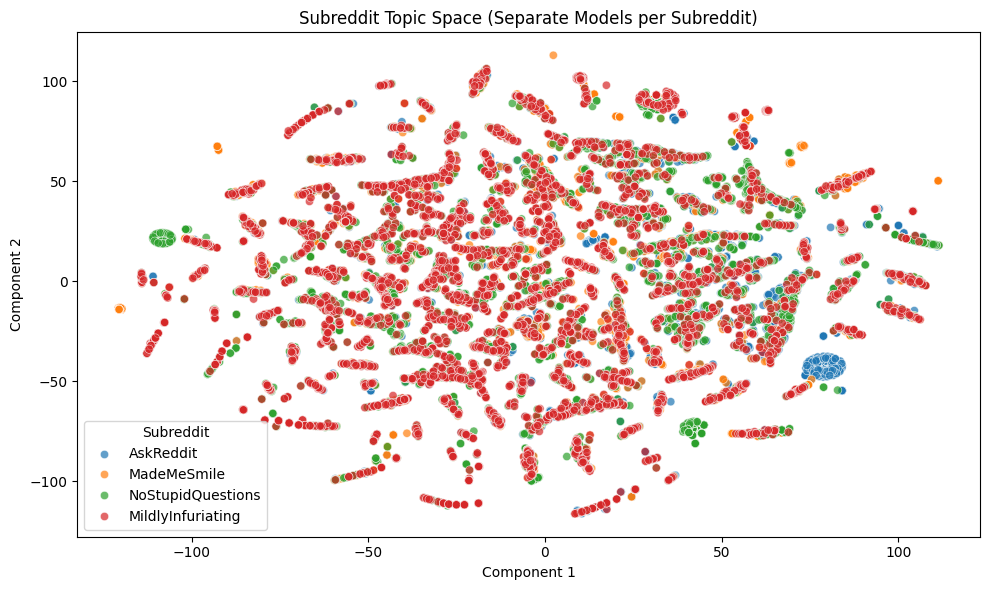

In [47]:
import pandas as pd
from gensim import corpora, models
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare storage for all topic vectors + labels
all_vectors = []
all_labels = []

# 2. Loop over each subreddit, process separately
for subreddit in combined_df['subreddit'].unique():
    texts = combined_df[combined_df['subreddit'] == subreddit]['words'].tolist()

    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=8,  # or tune this per subreddit
        passes=10,
        random_state=42
    )

    # 3. Get topic distribution per document
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc, minimum_probability=0.0)
        vector = [prob for _, prob in topic_dist]  # convert to flat vector
        all_vectors.append(vector)
        all_labels.append(subreddit)

# 4. Convert to matrix
X = np.array(all_vectors)

# 5. Reduce dimensionality (you can also use UMAP)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# 6. Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=all_labels, palette='tab10', alpha=0.7)
plt.title("Subreddit Topic Space (Separate Models per Subreddit)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Subreddit")
plt.tight_layout()
plt.show()